<h1 align="center">Machine Learning for Bioinformatics</h1>
<h3 align="center">Freie Universität Berlin - SoS 2024</h3>
<h5 align="center">Exercise Notebook Week 9 - Artificial Neural Network Architectures</h5>
<hr style="border:2px solid gray">

### Import python packages
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abc
import gzip
import pickle
from collections import Counter
from typing import Any, Dict, List, Optional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

---
# Assignment 1: Vanishing gradient
---

We generate some simple random data with $n = 1000$ samples and $p = 100$ features:

In [2]:
n = 1000
p = 100
X = np.random.rand(n, p)
y = np.random.randint(2, size=n).reshape(-1,1)

In [3]:
def eval_gradient(model, X, y, n_hidden = 100, n_repeat = 10):
    result = np.array([0.0] * n_hidden)
    for i in range(n_hidden):
        model.set_num_hidden_layers(i)
        for _ in range(n_repeat):
            result[i] += model.gradient_length(X, y, torch.nn.BCELoss())
    result /= n_repeat

    plt.plot(result)
    plt.xlabel('number of hidden layers')
    plt.ylabel('gradient magnitude')
    plt.show()

In [4]:
class GradientNetwork(abc.ABC, torch.nn.Module):
    def __init__(self, size, n=1):
        __metaclass__ = abc.ABCMeta
        super(GradientNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(size, size)
        self.linear2 = torch.nn.Linear(size, size)
        self.linear3 = torch.nn.Linear(size, 1)
        self.activation = torch.nn.Sigmoid()
        self.n = n

    @abc.abstractmethod
    def forward(self, x):
        return

    def gradient_length(self, X, y, loss_fn):
        self.zero_grad()
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        y_hat = self(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        return torch.norm(self.linear1.weight.grad).item()

    def set_num_hidden_layers(self, n):
        self.n = n

---
## 1.1 Vanishing gradient network
---

In [5]:
class VanishingGradientNetwork(GradientNetwork):
    def __init__(self, size, n=1):
        super(VanishingGradientNetwork, self).__init__(size, n=n)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        for _ in range(self.n):
            x = self.linear2(x)
            x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x

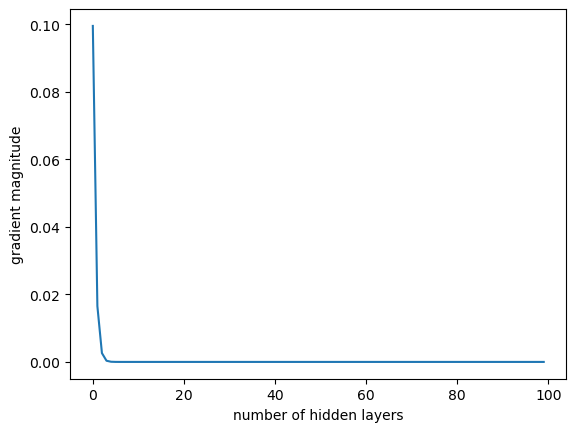

In [6]:
eval_gradient(VanishingGradientNetwork(p), X, y)

---
## 1.2 Network with skip connections
---

In [7]:
class SkipGradientNetwork(GradientNetwork):
    def __init__(self, size, n=1):
        super(SkipGradientNetwork, self).__init__(size, n=n)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        for _ in range(self.n):
            y = self.linear2(x)
            y = self.activation(y)
            x = x + y
        x = self.linear3(x)
        x = self.activation(x)
        return x

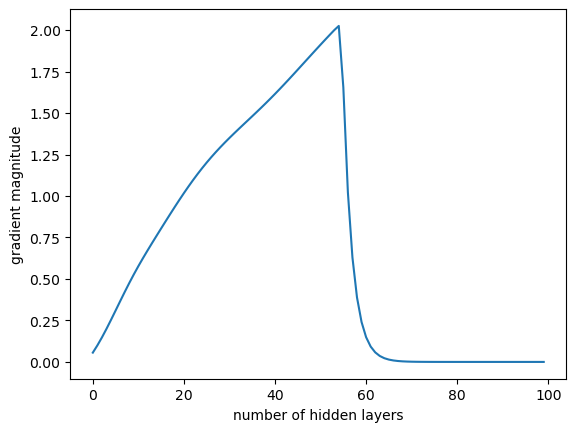

In [8]:
eval_gradient(SkipGradientNetwork(p), X, y)

---
## 1.3 Network with batch norm
---

In [9]:
class NormGradientNetwork(GradientNetwork):
    def __init__(self, size, n=1):
        super(NormGradientNetwork, self).__init__(size, n=n)
        # Define a 1D batch normalization here!
        #https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739
        self.norm1d = torch.nn.BatchNorm1d(size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        for _ in range(self.n):
            x = self.linear2(x)
            # Apply the batch normalization
            x = self.norm1d(x)

            x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x

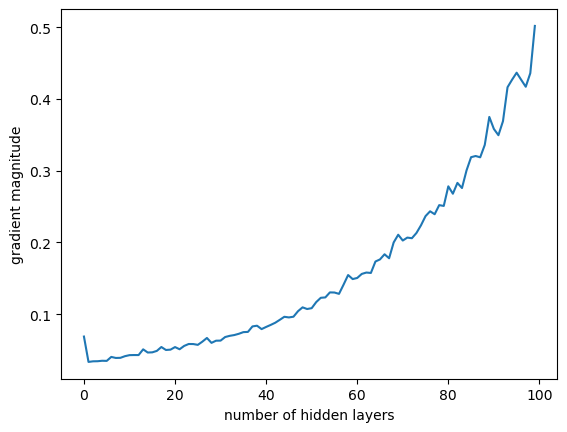

In [10]:
eval_gradient(NormGradientNetwork(p), X, y)

---
## 1.4 ReLU activation
---

In [11]:
class ReluGradientNetwork(GradientNetwork):
    def __init__(self, size, n=1):
        super(ReluGradientNetwork, self).__init__(size, n=n)
        # Define a ReLU activation
        self.relu_act = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        for _ in range(self.n):
            x = self.linear2(x)
            # Apply the ReLU activation
            x = self.relu_act(x)

        x = self.linear3(x)
        x = self.activation(x)
        return x

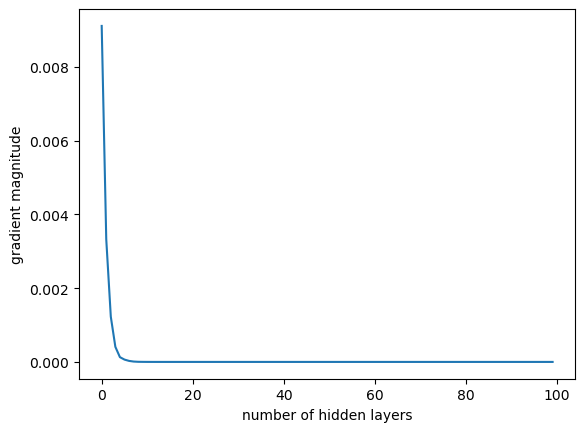

In [12]:
eval_gradient(ReluGradientNetwork(p), X, y)

In [13]:
class EluGradientNetwork(GradientNetwork):
    def __init__(self, size, n=1):
        super(EluGradientNetwork, self).__init__(size, n=n)
        # Define a ELU activation
        self.elu_act = torch.nn.ELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        for _ in range(self.n):
            x = self.linear2(x)
            # Apply the ELU activation
            x = self.elu_act(x)

        x = self.linear3(x)
        x = self.activation(x)
        return x

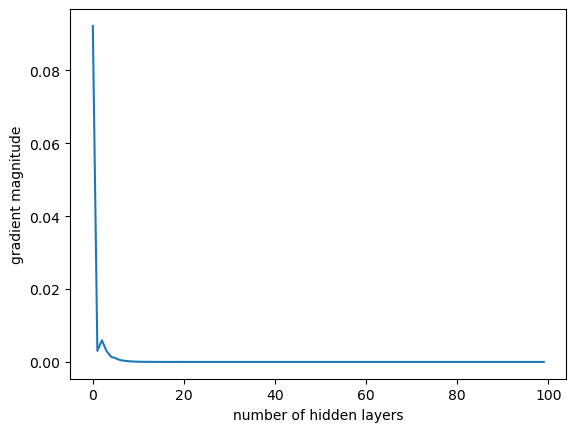

In [14]:
eval_gradient(EluGradientNetwork(p), X, y)

---
# Assignment 2: Prediction of active enhancers with CNNs
---

---
## 2.1 Torch dataset
---

In [15]:
class EnhancerData(Dataset):
    def __init__(self, path_to_data = 'exercise-09-data/enhancer_liver_onehot_balanced.pkl.gz'):
        
        ## import the dataset 
        with gzip.open(path_to_data, 'rb') as f:
            records, labels = pickle.load(f)
        # Convert records in one-hot format to a numeric matrix, which can be used as input to our model
        records = np.array(records, dtype=np.float32)
        # we will use the 1D convolution which takes input in format(data size, channels, seq length) - transpose
        self.X = np.transpose(records, (0, 2, 1))
        self.X = torch.tensor(self.X)
        # Create a vector on numeric labels
        self.y = labels.astype('float32').reshape(-1,1)
        self.y = torch.tensor(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {'X': self.X[idx], 'y': self.y[idx]}

In [16]:
def get_seq(seq):
   labels_again = np.argmax(seq, axis =0)
   labels_again = ['A' if i ==0 else ('C' if i==1 else('G' if i ==2 else('T')))for i in labels_again]
   return ''.join(labels_again)

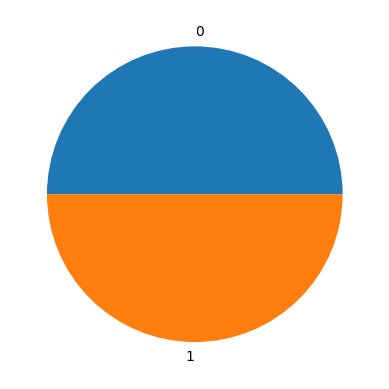

In [17]:
enhancer_data = EnhancerData()

plt.pie(Counter(enhancer_data.y[:,0].cpu().numpy()).values(), labels = [0, 1])
plt.show()

---
## 2.2 Lightning data
---

In [18]:
class LitEnhancerData(pl.LightningDataModule):
    def __init__(self, n_splits = 5, val_size = 0.2, batch_size = 32):
        super().__init__()
        self.val_size   = val_size
        self.batch_size = batch_size
        self.data       = EnhancerData()
        self.splits     = list(StratifiedKFold(n_splits).split(self.data.X, self.data.y))
        self.n_splits   = n_splits

    def setup_fold(self, k):
        self.k = k

    def setup(self, stage: Optional[str] = None):
        train_index, test_index = self.splits[self.k]
        # Split the data into training and testing
        data_size_val   = int(len(train_index)*self.val_size)
        data_size_train = len(train_index) - data_size_val
        data_train      = torch.utils.data.Subset(self.data, train_index)
        data_test       = torch.utils.data.Subset(self.data, test_index )
        data_train, data_val = torch.utils.data.random_split(data_train, [data_size_train, data_size_val])
        self.data_train = data_train
        self.data_test  = data_test
        self.data_val   = data_val

    def train_dataloader(self):
        return DataLoader(self.data_train, batch_size=self.batch_size, num_workers=0)#You should use num_workers=0 everywhere, otherwise you might get an error

    def val_dataloader(self):
        return DataLoader(self.data_val, batch_size=self.batch_size, num_workers=0)#You should use num_workers=0 everywhere, otherwise you might get an error

    def test_dataloader(self):
        return DataLoader(self.data_test, batch_size=self.batch_size, num_workers=0)#You should use num_workers=0 everywhere, otherwise you might get an error

---
## 2.3 Lightning utilities
---

In [19]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [20]:
class LitMetricTracker(pl.callbacks.Callback):
    def __init__(self):
        self.val_error_batch   = []
        self.val_error         = []
        self.train_error_batch = []
        self.train_error       = []
        self.test_y            = []
        self.test_y_hat        = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        self.train_error_batch.append(outputs['loss'].item())

    def on_train_epoch_end(self, *args, **kwargs):
        self.train_error.append(torch.mean(torch.tensor(self.train_error_batch)).item())
        self.train_error_batch = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        self.val_error_batch.append(outputs['val_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_error.append(torch.mean(torch.tensor(self.val_error_batch)).item())
        self.val_error_batch = []

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        self.test_y    .append(outputs['y'    ].detach().cpu())
        self.test_y_hat.append(outputs['y_hat'].detach().cpu())

    @property
    def test_predictions(self):
        y     = torch.cat(self.test_y)
        y_hat = torch.cat(self.test_y_hat)
        return y, y_hat

In [21]:
class LitProgressBar(pl.callbacks.progress.TQDMProgressBar):
    # Disable validation progress bar
    def on_validation_start(self, trainer, pl_module):
        pass
    def on_validation_end(self, trainer, pl_module):
        pass

---
## 1.3 Torch Network Module
---

With Lightning the implementation of the model stays within a Torch module. We want to implement a CNN model with two convolutional layers. Complete the implementation with the following layers (you must keep the exact sequential order):

* 1D convolutional layer with 4 input and 100 output channels. This means that we are using 100 kernels in out convolution. Set the stride to 1 and use a padding of 0
* 1D batch normalization layer
* Leaky ReLU activation
* Max pooling layer with a kernel size of 2, stride set to None and a padding of 0
* 1D convolutional layer with 100 input and 10 output channels. The remaining parameters are identical to the first convolutional layer
* 1D batch normalization layer
* Leaky ReLU activation

The output of the convolutional layers is first averaged and then given as input to a dense neural network for computing the final prediction.

In [22]:
class DetectActiveEnhancersNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional_sequence = torch.nn.Sequential(
            # Complete the implementation of the convolutional network
            torch.nn.Conv1d(4, 100, 4, stride=1, padding=0), #kernel size = 2
            torch.nn.BatchNorm1d(100), #number of features
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool1d(2, stride=None, padding=0),
            torch.nn.Conv1d(100, 10, 4, stride=1, padding=0),
            torch.nn.BatchNorm1d(10),
            torch.nn.LeakyReLU()
        )
        self.linear_sequence = torch.nn.Sequential(   
            torch.nn.Linear(10,1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.convolutional_sequence(x)
        # Average output of convolutional layers
        x = x.mean(2)
        x = self.linear_sequence(x)
        return x

---
## 1.4 Lightning Module: A wrapper for training pytorch modules
---

In [23]:
class LitDetectActiveEnhancersNetwork(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        # Save all hyperparameters to `hparams` (e.g. lr)
        self.save_hyperparameters()
        self.loss = torch.nn.BCELoss()
        self.train_loss = []
        self.val_loss   = []
        self.model = DetectActiveEnhancersNetwork()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams["lr"] )
        scheduler = {"scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer,
                        patience=5,
                        mode='min',
                        verbose=True),
                    "interval": "epoch",
                    'monitor': 'val_loss'
                    }
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_index):
        """Train model on a single batch"""
        X_batch = batch['X']
        y_batch = batch['y']
        y_hat   = self(X_batch)
        loss    = self.loss(y_hat, y_batch)
        # Send metrics to progress bar. We also don't want results
        # logged at every step, but let the logger accumulate the
        # results at the end of every epoch
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        # Return whatever we might need in callbacks. Lightning automtically minimizes
        # the item called 'loss', which must be present in the returned dictionary
        return {'loss': loss}

    def validation_step(self, batch, batch_index):
        """Validate model on a single batch"""
        X_batch = batch['X']
        y_batch = batch['y']
        y_hat   = self(X_batch)
        loss    = self.loss(y_hat, y_batch)
        # Send metrics to progress bar. We also don't want results
        # logged at every step, but let the logger accumulate the
        # results at the end of every epoch
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        # Return whatever we might need in callbacks
        return {'val_loss': loss}

    def test_step(self, batch, batch_index):
        """Test model on a single batch"""
        X_batch = batch['X']
        y_batch = batch['y']
        y_hat   = self(X_batch)
        loss    = self.loss(y_hat, y_batch)
        # Log whatever we want to aggregate later
        self.log('test_loss', loss, batch_size=len(batch))
        # Return predictions
        return {'y': y_batch, 'y_hat': y_hat, 'test_loss': loss}

---
## 1.5 Main cross-validation loop
---

In [24]:
data = LitEnhancerData(n_splits = 5)

y_hat = np.array([])
y     = np.array([])

for fold in range(data.n_splits):

    data.setup_fold(fold)

    model = LitDetectActiveEnhancersNetwork()

    mt = LitMetricTracker()
    es = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=10)
    cp = ModelCheckpoint()
    pb = LitProgressBar()

    # Train model on train data and use validation data for early stopping, change accelerator
    # to 'cpu' if you do not have a GPU that can be used for computations
    trainer = pl.Trainer(max_epochs=1000, accelerator='gpu', devices=1, callbacks=[pb, es, mt, cp], enable_progress_bar=True, logger=False)
    trainer.fit(model, data)

    # Get best model from checkpoint
    #model = model.load_from_checkpoint(cp.best_model_path)
    model = LitDetectActiveEnhancersNetwork.load_from_checkpoint(cp.best_model_path)

    # Test estimated model on test data
    trainer.test(model, data)

    # Get predictions from test run
    test_y, test_y_hat = mt.test_predictions

    # Evaluate model
    y_hat = np.append(y_hat, test_y_hat)
    y     = np.append(y    , test_y)

C:\Users\vevit\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\vevit\Documents\DS_Workspace\MLinBioinformatics\Project7\09-ann-architectures-exercise\checkpoints exists and is not empty.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 00066: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00073: reducing learning rate of group 0 to 1.0000e-05.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5741874575614929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00084: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00093: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00100: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00106: reducing learning rate of group 0 to 1.0000e-08.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5839994549751282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 00091: reducing learning rate of group 0 to 1.0000e-04.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5815825462341309
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00052: reducing learning rate of group 0 to 1.0000e-05.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5786209106445312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 00058: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00065: reducing learning rate of group 0 to 1.0000e-05.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5431035757064819
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Text(0.5, 1.0, '5-fold CV ROC-Curve (AUC: 0.79)')

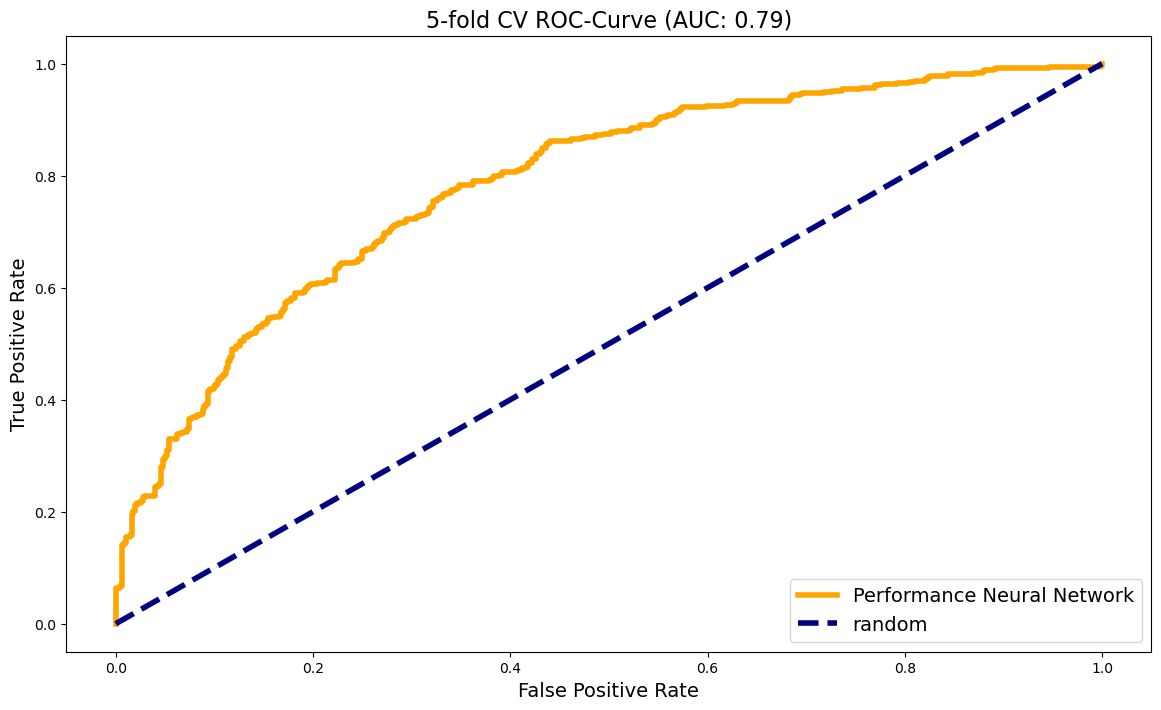

In [25]:
roc_auc = roc_auc_score(y_score=y_hat, y_true=y)
tpr, fpr, _ = roc_curve(y_score=y_hat, y_true=y)

fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, label='Performance Neural Network', lw=4, color='orange')
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='random')
plt.legend(loc='lower right', fontsize = 14)
plt.title("5-fold CV ROC-Curve (AUC: {:0.2f})".format(roc_auc), fontsize = 16)

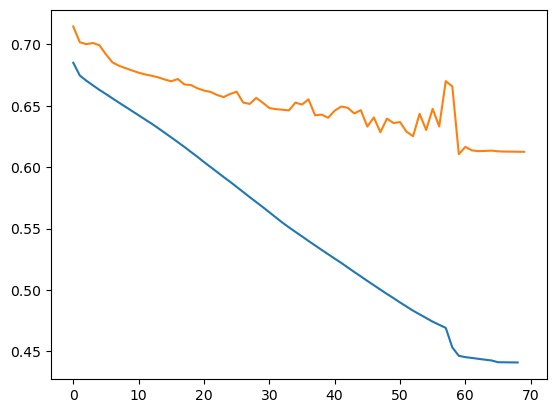

In [26]:
# Plot train and validation error of the last CV fold
plt.plot(mt.train_error)
plt.plot(mt.val_error)
plt.show()